# Исследование поведения пользователей мобильного приложения

### Описание проекта

В данном проекте будет исследовано поведение пользователей мобильного приложения интернет-магазина. Мы изучим воронку прожад, а также исследуем результаты A/A/B-эксперимента (у эксперементальной группы изменены шрифты в приложении). 

Задание: изучить воронку продаж; исследовать результаты A/A/B-эксперимента.

### Оглавление

[1. Подготовка к анализу данных](#section1)  
[1.1 Загрузка датасета](#section1_1)  
[1.2 Предобработка данных. Проверка на пропуски и дубликаты, изменение типов данных](#section1_2)  
[2. Проверка поступивших данных](#section2)  
[2.1 Количество событий](#section2_1)  
[2.2 Количество уникальных пользователей](#section2_2)  
[2.3 Среднее количество событий на пользователя](#section2_3)  
[2.4 Изучение временного периода получения данных](#section2_4)  
[2.5 Исследование отброшенных данных](#section2_5)  
[2.6 Проверка количества пользователей эксперементальных групп](#section2_6)  
[3. Воронка событий](#section3)  
[3.1 Сгрупированная таблица с количеством пользователей, количеством событий и долей пользователей от общего количества](#section3_1)  
[3.2 Воронка событий](#section3_2)  
[4. Проверка на равенство долей](#section4)  
[4.1 Количество пользователей в эксперементальных группах. Добавление новых колонок к data_grouped](#section4_1)  
[4.2 Проверка гипотезы о равенстве долей](#section4_2)  
[Общий вывод](#section5)  


<a id='section1'> <a/>

## 1. Подготовка к анализу данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import math as mth
from plotly import graph_objects as go

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<a id='section1_1'> <a/>

1.1 Загрузка датасета

In [3]:
# Путь к папке с датасетом
path = '/content/drive/My Drive/yandex.practicum projects/datasets/9. Test project 2/'

# Создание датафрейма, общая информация
data_logs = pd.read_csv(path + 'logs_exp.csv', sep='\t')
display(data_logs.head())
data_logs.info()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [4]:
data_logs.columns = ['event_name', 'id', 'event_time_unix', 'exp_id']

event_name — название события  
id — уникальный идентификатор пользователя  
event_time_unix — время события в формате unix time  
exp_id — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная  
<a id='section1_2'> <a/>

1.2 Предобработка данных. Проверка на пропуски и дубликаты, изменение типов данных.

In [5]:
# Добавление столбца с датой и временем
data_logs['event_time'] = pd.to_datetime(data_logs['event_time_unix'], unit = 's')

# Добавление столбца с датой
data_logs['event_date'] = data_logs['event_time'].astype('datetime64[D]')

In [6]:
# Количество дубликатов
data_logs.duplicated().sum()

413

In [7]:
# id с наибольши количеством дубликатов
data_logs[data_logs.duplicated() == True].groupby('id')['event_name'].count().sort_values(ascending=False)[:10]

id
3610536745613892312    41
3473691793382022823    23
4980045449118619005    11
6932517045703054087     9
6394616444764198947     7
636437379427729086      7
5767286434014984014     6
197027893265565660      5
3755777888701401447     5
7738058666231999878     5
Name: event_name, dtype: int64

Посмотрим на дубликаты событий по id с наибольшим количеством дубликатов

In [8]:
display(data_logs[(data_logs['id'] == 3610536745613892312) & (data_logs.duplicated() == True)])

display(data_logs[(data_logs['id'] == 3473691793382022823) & (data_logs.duplicated() == True)])

display(data_logs[(data_logs['id'] == 4980045449118619005) & (data_logs.duplicated() == True)])

,event_name,id,event_time_unix,exp_id,event_time,event_date
76243,PaymentScreenSuccessful,3610536745613892312,1564807190,248,2019-08-03 04:39:50,2019-08-03
76245,PaymentScreenSuccessful,3610536745613892312,1564807191,248,2019-08-03 04:39:51,2019-08-03
76250,PaymentScreenSuccessful,3610536745613892312,1564807194,248,2019-08-03 04:39:54,2019-08-03
76252,PaymentScreenSuccessful,3610536745613892312,1564807195,248,2019-08-03 04:39:55,2019-08-03
76256,PaymentScreenSuccessful,3610536745613892312,1564807197,248,2019-08-03 04:39:57,2019-08-03
76260,PaymentScreenSuccessful,3610536745613892312,1564807200,248,2019-08-03 04:40:00,2019-08-03
76264,PaymentScreenSuccessful,3610536745613892312,1564807202,248,2019-08-03 04:40:02,2019-08-03
83762,PaymentScreenSuccessful,3610536745613892312,1564824827,248,2019-08-03 09:33:47,2019-08-03
83780,PaymentScreenSuccessful,3610536745613892312,1564824841,248,2019-08-03 09:34:01,2019-08-03
83789,PaymentScreenSuccessful,3610536745613892312,1564824846,248,2019-08-03 09:34:06,2019-08-03


,event_name,id,event_time_unix,exp_id,event_time,event_date
38527,Tutorial,3473691793382022823,1564697301,248,2019-08-01 22:08:21,2019-08-01
38539,Tutorial,3473691793382022823,1564697331,248,2019-08-01 22:08:51,2019-08-01
38542,Tutorial,3473691793382022823,1564697346,248,2019-08-01 22:09:06,2019-08-01
38544,Tutorial,3473691793382022823,1564697347,248,2019-08-01 22:09:07,2019-08-01
38547,Tutorial,3473691793382022823,1564697355,248,2019-08-01 22:09:15,2019-08-01
38548,Tutorial,3473691793382022823,1564697355,248,2019-08-01 22:09:15,2019-08-01
38563,Tutorial,3473691793382022823,1564697509,248,2019-08-01 22:11:49,2019-08-01
38564,Tutorial,3473691793382022823,1564697509,248,2019-08-01 22:11:49,2019-08-01
38565,Tutorial,3473691793382022823,1564697509,248,2019-08-01 22:11:49,2019-08-01
38566,Tutorial,3473691793382022823,1564697509,248,2019-08-01 22:11:49,2019-08-01


,event_name,id,event_time_unix,exp_id,event_time,event_date
21001,PaymentScreenSuccessful,4980045449118619005,1564665638,247,2019-08-01 13:20:38,2019-08-01
21003,PaymentScreenSuccessful,4980045449118619005,1564665639,247,2019-08-01 13:20:39,2019-08-01
21004,PaymentScreenSuccessful,4980045449118619005,1564665639,247,2019-08-01 13:20:39,2019-08-01
21006,PaymentScreenSuccessful,4980045449118619005,1564665639,247,2019-08-01 13:20:39,2019-08-01
21008,PaymentScreenSuccessful,4980045449118619005,1564665640,247,2019-08-01 13:20:40,2019-08-01
21009,PaymentScreenSuccessful,4980045449118619005,1564665640,247,2019-08-01 13:20:40,2019-08-01
21010,PaymentScreenSuccessful,4980045449118619005,1564665640,247,2019-08-01 13:20:40,2019-08-01
21011,PaymentScreenSuccessful,4980045449118619005,1564665640,247,2019-08-01 13:20:40,2019-08-01
21015,PaymentScreenSuccessful,4980045449118619005,1564665641,247,2019-08-01 13:20:41,2019-08-01
21020,PaymentScreenSuccessful,4980045449118619005,1564665643,247,2019-08-01 13:20:43,2019-08-01


In [9]:
# Наиболее часто встречающиеся дубликаты событий
data_logs[data_logs.duplicated() == True].groupby('event_name')['id'].count().sort_values(ascending=False)

event_name
PaymentScreenSuccessful    195
MainScreenAppear           104
CartScreenAppear            63
Tutorial                    34
OffersScreenAppear          17
Name: id, dtype: int64

In [10]:
# Наибольшее количество дубликатов в один момент времени 
data_logs[data_logs.duplicated() == True].groupby(['id', 'event_time_unix']).\
                                          agg({'event_time':'count'}).\
                                          sort_values('event_time',ascending=False)[:10]

,,event_time
id,event_time_unix,
3473691793382022823,1564697509,4
636437379427729086,1564726206,4
3473691793382022823,1564697513,4
4980045449118619005,1564665640,4
7757756163339431950,1564857429,3
5767286434014984014,1565004352,3
3528217211962170139,1564658003,3
6932517045703054087,1565024403,3
3473691793382022823,1564697512,3


Как мы видим, наиболее часто встречающися дубликаты - успешный экран оплаты. При этом у одного пользователя в одну секунду может произойти до 5 одинаковых записей одного события.

Исходя из логики, что одно и тоже действие в одру и ту же секунду одного и того же пользователя с большей вероятностью является технической ошибкой, при которой произошло до 5 записей одного действия - удалим дубликаты.

In [11]:
# Удаление дубликатов
data_logs = data_logs.drop_duplicates().reset_index(drop=True)

In [12]:
# Проверка на пропуски
data_logs.isna().sum()

event_name         0
id                 0
event_time_unix    0
exp_id             0
event_time         0
event_date         0
dtype: int64

### Вывод

На данном этапе мы загрузили датафрейм с логами пользователей и ознакомились с ним. Было осуществлено преобразование времени из unix-формата, проведена проверка на пропуски и дубликаты. Всего было найдено 413 дубликатов, пропуски не обнаружены.

Исходя из логики, что одно и тоже действие в одру и ту же секунду одного и того же пользователя с большей вероятностью является технической ошибкой, при которой произошло до 5 записей одного действия.

В результате было принято решение об удалении дубликатов. 

<a id='section2'> <a/>

## 2. Проверка поступивших данных

<a id='section2_1'> <a/>

2.1 Количество событий

In [13]:
print('Общее количество событий:', data_logs['event_name'].count())

# Количество каждого события
data_logs.groupby('event_name').agg({'id':'count'}).sort_values('id', ascending=False)

Общее количество событий: 243713


,id
event_name,
MainScreenAppear,119101
OffersScreenAppear,46808
CartScreenAppear,42668
PaymentScreenSuccessful,34118
Tutorial,1018


Всего в данных логах представлено 5 различных событий: 'MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful', 'Tutorial'.

<a id='section2_2'> <a/>

2.2 Количество уникальных пользователей

In [14]:
print('Количество уникальных пользователей в логе: {}'.format(data_logs['id'].nunique()))

Количество уникальных пользователей в логе: 7551


Всего в датафрейме имеется информация о 7551 уникальном пользователе.

<a id='section2_3'> <a/>

2.3 Среднее количество событий на пользователя

In [15]:
# Пользователи с наибольшим количеством событий
data_logs.groupby('id').agg({'event_name':'count'}).sort_values('event_name', ascending=False)[:10]

,event_name
id,
6304868067479728361,2307
197027893265565660,1998
4623191541214045580,1768
6932517045703054087,1439
1754140665440434215,1221
3337471580007169353,1186
7738058666231999878,888
1055544042902443290,854
4713748699910253089,824


In [16]:
print('Количество событий в среднем приходящихся на одного пользователя: {:.2f}'.\
      format(data_logs['event_name'].count() / data_logs['id'].nunique()))

print('Медианное количество событий приходящихся на одного пользователя: {:.2f}'.\
      format(int(data_logs.groupby('id').agg({'event_name':'count'}).sort_values('event_name', ascending=False).median())))

print('Количество уникальных событий в среднем приходящихся на одного пользователя: {:.2f}'.\
      format(data_logs.groupby('event_name')['id'].nunique().sum() / data_logs['id'].nunique()))

Количество событий в среднем приходящихся на одного пользователя: 32.28
Медианное количество событий приходящихся на одного пользователя: 20.00
Количество уникальных событий в среднем приходящихся на одного пользователя: 2.67


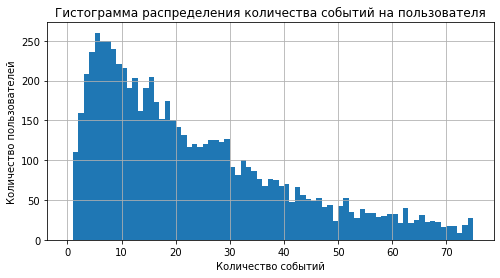

In [17]:
data_logs.groupby('id').agg({'event_name':'count'}).\
    hist(bins=75, range=(0,75), figsize=(8,4))
plt.title('Гистограмма распределения количества событий на пользователя')
plt.xlabel('Количество событий')
plt.ylabel('Количество пользователей')
plt.show()

В среднем на одного уникального пользователя приходится 32.28 события, при этом медианная величина равна 20 событиям. Данные сильные различия обусловлены сильными выбросами. Так, например, максимальное количество событий у одного пользователя равно 2307 собыиям.

На гистограмме пик у пользователей приходится на 5 событий с дальнейшим постепенным снижением.

<a id='section2_4'> <a/>

2.4 Изучение временного периода получения данных

In [18]:
print('Минимальная дата в данных: {}'.format(data_logs['event_time'].min()))
print('Максимальная дата в данных: {}'.format(data_logs['event_time'].max()))

Минимальная дата в данных: 2019-07-25 04:43:36
Максимальная дата в данных: 2019-08-07 21:15:17


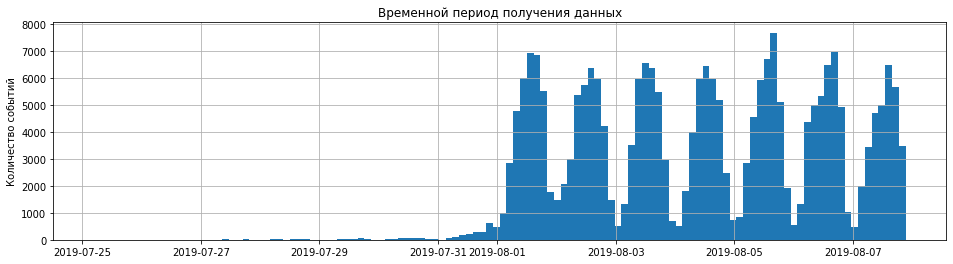

In [19]:
data_logs['event_time'].hist(bins=120, figsize=(16,4))
plt.title('Временной период получения данных')
plt.xlabel('')
plt.ylabel('Количество событий')
plt.show()

In [20]:
data_logs_clean = data_logs[data_logs['event_date'] >= '2019-08-01'].reset_index(drop=True)

Как мы видим основной массив данных начал поступать с 2019-08-01, данную дату можно считать началом эксперемента. Данные за более старый период мы исключили.

<a id='section2_5'> <a/>

2.5 Исследование отброшенных данных

In [21]:
print('Общее количество отброшенных событий:', data_logs[data_logs['event_date'] < '2019-08-01']['event_name'].count())

# Количество отброшенных событий
data_logs[data_logs['event_date'] < '2019-08-01'].groupby('event_name').agg({'id':'count'}).sort_values('id', ascending=False)

Общее количество отброшенных событий: 2826


,id
event_name,
MainScreenAppear,1773
OffersScreenAppear,475
CartScreenAppear,365
PaymentScreenSuccessful,200
Tutorial,13


In [22]:
print('Процент отсеянных по дате данных: {:.2%}'.\
      format(len(data_logs[data_logs['event_date'] < '2019-08-01']) / len(data_logs)))

Процент отсеянных по дате данных: 1.16%


In [23]:
print('Количество отсеянных уникальных пользователей: {}'.\
      format(data_logs['id'].nunique() - data_logs_clean['id'].nunique()))

Количество отсеянных уникальных пользователей: 17


По дате нами было отсеяно еще 2826 событий, что составляет 1.16% от общего числа. Количество уникальных пользователей стало меньше на 17 пользователей. 

<a id='section2_6'> <a/>

2.6 Проверка количества пользователей эксперементальных групп

In [24]:
data_logs_clean.groupby('exp_id')['id'].count()

exp_id
246    79302
247    77022
248    84563
Name: id, dtype: int64

### Вывод

В ходе проверки поступивших данных было замечено, что часть информации поступила к нам еще до начала эксперемента. За отсчет начала эксперемента было взято 1 августа 2019 года, боле ранние данные были отсеяны. Общее количество отброшенных событий составляет 2826 события. Это равно 1.16%  от общего числа.

В среднем на одного уникального пользователя приходится 32.28 события, при этом медианная величина равна 20 событиям. Данные сильные различия обусловлены сильными выбросами. Всего в датафрейме представлено  7551 уникальных пользовелей.

<a id='section3'> <a/>

## 3. Воронка событий

<a id='section3_1'> <a/>

3.1 Сгрупированная таблица с количеством пользователей, количеством событий и долей пользователей от общего количества

In [25]:
data_grouped = data_logs_clean.\
    groupby('event_name').\
    agg({'id':'nunique', 'event_date':'count'}).\
    rename(columns={'id':'users', 'event_date':'events'}).\
    sort_values('events', ascending=False)

data_grouped['prop.'] = (data_grouped['users'] / data_logs_clean['id'].nunique()).round(4)

data_grouped

,users,events,prop.
event_name,,,
MainScreenAppear,7419,117328,0.9847
OffersScreenAppear,4593,46333,0.6096
CartScreenAppear,3734,42303,0.4956
PaymentScreenSuccessful,3539,33918,0.4697
Tutorial,840,1005,0.1115


Логичено предполодить, что события происходят в следующем порядке: "MainScreenAppear">"OffersScreenAppear">"CartScreenAppear">"PaymentScreenSuccessful".  
Событие "Tutorial" не втраивается в последовательную цепочку, т.к. является обособленным действием. Оно не является начальным, промежуточным или завершающим событием, соответственно ее не нужно учитывать при построении воронки событий.

<a id='section3_2'> <a/>

3.2 Воронка событий

In [26]:
fig = go.Figure(go.Funnel(
    y = ["Главный экран","Предложение", "Корзина", "Оплата"],
    x = [int(data_grouped['users'][:1]),
         int(data_grouped['users'][1:2]),
         int(data_grouped['users'][2:3]),
         int(data_grouped['users'][3:4])]
    ))
fig.show()

### Вывод

В данном разделе было определено, что события происходят в следующем порядке: "MainScreenAppear">"OffersScreenAppear">"CartScreenAppear">"PaymentScreenSuccessful".
Событие "Tutorial" не втраивается в данную последовательную цепочку.

При этом, изучая воронку событий видно, что наибольшее количество пользователей теряется при переходе от события "MainScreenAppear" к событию "OffersScreenAppear" (потеря 38% относительно "MainScreenAppear"). Доля пользователей, прошедших всю воронку составляет 47.7%.

<a id='section4'> <a/>

## 4. Проверка на равенство долей

<a id='section4_1'> <a/>

4.1 Количество пользователей в эксперементальных группах. Добавление новых колонок к data_grouped

In [27]:
n_users_А1 = data_logs_clean[data_logs_clean['exp_id'] == 246]['id'].nunique()
print('В эксперементальной группе А1 {} уникальных пользователей'.format(n_users_А1))

n_users_А2 = data_logs_clean[data_logs_clean['exp_id'] == 247]['id'].nunique()
print('В эксперементальной группе А2 {} уникальных пользователей'.format(n_users_А2))

n_users_B = data_logs_clean[data_logs_clean['exp_id'] == 248]['id'].nunique()
print('В эксперементальной группе B {} уникальных пользователей'.format(n_users_B))

n_users_AA = n_users_А1 + n_users_А2
print('В объединенной эксперементальной группе АА {} уникальных пользователей'.format(n_users_AA))

В эксперементальной группе А1 2484 уникальных пользователей
В эксперементальной группе А2 2513 уникальных пользователей
В эксперементальной группе B 2537 уникальных пользователей
В объединенной эксперементальной группе АА 4997 уникальных пользователей


In [28]:
# Добавление новых колонок к data_grouped.
# Количество пользователей, событий и доля пользователей от общего количества по группам

data_grouped['prop., %'] = (data_grouped['users'] / data_logs_clean['id'].nunique()).round(4)

data_grouped[['users A1','events A1']] = data_logs_clean[data_logs_clean['exp_id'] == 246].\
    groupby('event_name').\
    agg({'id':'nunique', 'event_date':'count'})
data_grouped['prop.A1'] = (data_grouped['users A1'] / n_users_А1).round(4)

data_grouped[['users A2','events A2']] = data_logs_clean[data_logs_clean['exp_id'] == 247].\
    groupby('event_name').\
    agg({'id':'nunique', 'event_date':'count'})
data_grouped['prop.A2'] = (data_grouped['users A2'] / n_users_А2).round(4)

data_grouped[['users B','events B']] = data_logs_clean[data_logs_clean['exp_id'] == 248].\
    groupby('event_name').\
    agg({'id':'nunique', 'event_date':'count'})
data_grouped['prop.B'] = (data_grouped['users B'] / n_users_B).round(4)

data_grouped['users AA'] = data_grouped['users A1'] + data_grouped['users A2']
data_grouped['events AA'] = data_grouped['events A1'] + data_grouped['events A2']
data_grouped['prop.AA'] = (data_grouped['users AA'] / n_users_AA).round(4)

data_grouped

,users,events,prop.,"prop., %",users A1,events A1,prop.A1,users A2,events A2,prop.A2,users B,events B,prop.B,users AA,events AA,prop.AA
event_name,,,,,,,,,,,,,,,,
MainScreenAppear,7419,117328,0.9847,0.9847,2450,37676,0.9863,2476,39090,0.9853,2493,40562,0.9827,4926,76766,0.9858
OffersScreenAppear,4593,46333,0.6096,0.6096,1542,14767,0.6208,1520,15179,0.6049,1531,16387,0.6035,3062,29946,0.6128
CartScreenAppear,3734,42303,0.4956,0.4956,1266,14690,0.5097,1238,12434,0.4926,1230,15179,0.4848,2504,27124,0.5011
PaymentScreenSuccessful,3539,33918,0.4697,0.4697,1200,11852,0.4831,1158,9981,0.4608,1181,12085,0.4655,2358,21833,0.4719
Tutorial,840,1005,0.1115,0.1115,278,317,0.1119,283,338,0.1126,279,350,0.1100,561,655,0.1123


Количество уникальных пользователей в эксперементальных группах А1, А2, В соответственно равно 2484, 2513, 2537 пользователей. Количество пользователей между группами различается незначительно.

Так же на данном этапе были добавлены поля с информацией о пользовалелях, событиях и долях по группам.

<a id='section4_2'> <a/>

4.2 Проверка гипотез о равенстве долей

In [29]:
def i(number,group1, group2, n_users1, n_users2):
    """
    Функция для проверки гипотезы о равенстве долей
    """
    alpha = 0.05 / 16  # поправка Бонферрони по количеству проведенных тестов
    p1 = data_grouped['prop.'+group1][number]
    p2 = data_grouped['prop.'+group2][number]

    p_combined = (data_grouped['users '+group1][number] + data_grouped['users '+group2][number]) / (n_users1 + n_users2)
    difference = p1 - p2
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/n_users1 + 1/n_users2))

    distr = st.norm(0,1) 
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print(data_grouped.index[number])
    print('p-значение: ', p_value.round(4))
    
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
    print()

**Проверка групп А1 и А2**

Перед тем, как проводить A/B тест убедимся, что данные не содержат аномалий и выбросов, инструмент «деления» трафика работает без ошибок, данные отправляются в системы аналитики корректно. Для этого мы проведем А/А тест. Если при сборе данных не возникло ошибок - различий между группами А1 и А2 не будет. В случае возникновения различий - наиболее вероятно, что данные были собраны неккорректно и проведение A/B эксперемента невозможно.

In [30]:
print('В эксперементальной группе А1 {} уникальных пользователей'.format(n_users_А1))
print('В эксперементальной группе А2 {} уникальных пользователей'.format(n_users_А2))

print('Различие между группами в {} уникальных пользователей'.format(n_users_А2-n_users_А1),\
      'или {:.2%}'.format((n_users_А2-n_users_А1)/n_users_А2))

В эксперементальной группе А1 2484 уникальных пользователей
В эксперементальной группе А2 2513 уникальных пользователей
Различие между группами в 29 уникальных пользователей или 1.15%


In [31]:
print('В эксперементальной группе А1 {} событий'.\
        format(data_logs_clean[data_logs_clean['exp_id'] == 246]['event_name'].count()))
print('В эксперементальной группе А2 {} событий'.\
        format(data_logs_clean[data_logs_clean['exp_id'] == 247]['event_name'].count()))

print('Различие между группами в {} событий'.\
        format((data_logs_clean[data_logs_clean['exp_id'] == 246]['event_name'].count()) -\
               (data_logs_clean[data_logs_clean['exp_id'] == 247]['event_name'].count())),\
      'или {:.2%}'.format(((data_logs_clean[data_logs_clean['exp_id'] == 246]['event_name'].count()) -\
                           (data_logs_clean[data_logs_clean['exp_id'] == 247]['event_name'].count())) /\
                            data_logs_clean[data_logs_clean['exp_id'] == 246]['event_name'].count()))

В эксперементальной группе А1 79302 событий
В эксперементальной группе А2 77022 событий
Различие между группами в 2280 событий или 2.88%


Нулевая гипотеза (H0) - Доля конверсии по группе А1 равна доле конверсии по группе A2.  
Альтернативная гипотеза (H1) - Доля конверсии по группе А1 не равна доле конверсии по группе A2, между долями есть значимая разница.

In [32]:
# Проверка групп А1 и А2
i(0,'A1', 'A2', n_users_А1, n_users_А2)
i(1,'A1', 'A2', n_users_А1, n_users_А2)
i(2,'A1', 'A2', n_users_А1, n_users_А2)
i(3,'A1', 'A2', n_users_А1, n_users_А2)

MainScreenAppear
p-значение:  0.7652
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение:  0.2486
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение:  0.2268
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение:  0.1144
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Как мы видим, нет оснований считать доли групп А1 и А2 разными. Можно предположить, что разбиение на группы работает корректно.

**Проверка групп А1 и B**

Нулевая гипотеза (H0) - Доля конверсии по группе А1 равна доле конверсии по группе B.  
Альтернативная гипотеза (H1) - Доля конверсии по группе А1 не равна доле конверсии по группе B, между долями есть значимая разница.

In [33]:
# Проверка групп А1 и B
i(0,'A1', 'B', n_users_А1, n_users_B)
i(1,'A1', 'B', n_users_А1, n_users_B)
i(2,'A1', 'B', n_users_А1, n_users_B)
i(3,'A1', 'B', n_users_А1, n_users_B)

MainScreenAppear
p-значение:  0.3024
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение:  0.2085
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение:  0.0777
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение:  0.2118
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**При значении ɑ=0.1 без использования поправки Бонферрони проверка групп А1 и B на событии CartScreenAppear показывает, что между долями есть значимая разница. При этом необходимо учитывать, что при ɑ=0.1 каждый десятый раз можно получать ложный результат. Для этого мы используем поправку Бонферрони.**

**Проверка групп А2 и B**

Нулевая гипотеза (H0) - Доля конверсии по группе А2 равна доле конверсии по группе B.  
Альтернативная гипотеза (H1) - Доля конверсии по группе А2 не равна доле конверсии по группе B, между долями есть значимая разница.

In [34]:
# Проверка групп А2 и B
i(0,'A2', 'B', n_users_А2, n_users_B)
i(1,'A2', 'B', n_users_А2, n_users_B)
i(2,'A2', 'B', n_users_А2, n_users_B)
i(3,'A2', 'B', n_users_А2, n_users_B)

MainScreenAppear
p-значение:  0.4621
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение:  0.919
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение:  0.5793
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение:  0.7377
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Проверка групп АА и B**

Нулевая гипотеза (H0) - Доля конверсии по группе АA равна доле конверсии по группе B.  
Альтернативная гипотеза (H1) - Доля конверсии по группе АA не равна доле конверсии по группе B, между долями есть значимая разница.

In [35]:
# Проверка групп АА и B
i(0,'AA', 'B', n_users_AA, n_users_B)
i(1,'AA', 'B', n_users_AA, n_users_B)
i(2,'AA', 'B', n_users_AA, n_users_B)
i(3,'AA', 'B', n_users_AA, n_users_B)

MainScreenAppear
p-значение:  0.2996
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение:  0.4342
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение:  0.1811
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение:  0.5989
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



### Вывод

На данном этапе нами было проведено 16 тестов о равенстве долей групп А1, А2, В и АА. Была использована поправка Бонферрони, для избегания ошибок (разделили значение ɑ на 16, по количеству проведенных тестов). При значении ɑ=0.1 без использования поправки Бонферрони проверка групп А1 и B на событии CartScreenAppear показывает, что между долями есть значимая разница. При этом необходимо учитывать, что при ɑ=0.1 каждый десятый раз можно получать ложный результат.  

Подсчет проводился от общего количества уникальных пользователей в группе, т.к. первостепенно важно итоговое количество пользователей, совершивших покупку.

Согласно проведенным тестам, нет оснований считать доли групп А1 и А2 разными. Можно предположить, что разбиение на группы работает корректно.

Также, согласно проведенным тестам, изменение шрифта в приложении не приводит к статистически значимым результатам, различия между контрольными и эксперементальной группами не наблюдается.

<a id='section5'> <a/>

## Общий вывод

В данном исследовании была изучена воронка продаж и исследованы результаты A/A/B-эксперимента по изменению шрифта в мобильном приложении.

Для построения воронки продаж была использована следующая цепочка событий: "MainScreenAppear">"OffersScreenAppear">"CartScreenAppear">"PaymentScreenSuccessful". Событие "Tutorial" не втраивается в данную последовательную цепочку, т.к. независимо от них.

По воронке событий видно, что наибольшее количество пользователей теряется при переходе от события "MainScreenAppear" к событию "OffersScreenAppear" (потеря 38% относительно "MainScreenAppear"). При этом после данного этапа потеря пользователей на слудующих этапах уже значительно меньше. Доля пользователей, прошедших всю воронку составляет 47.7% от всех пользователей в группе.

Согласно проведенным тестам, нет оснований считать доли групп А1 и А2 разными. Можно предположить, что разбиение на группы работает корректно.

По результатам проведенного эксперемента видно, что изменение шрифта в приложении не приводит к статистически значимым результатам, различий между контрольными и эксперементальной группами не наблюдается.